# here we will get author full names, and use validated packages to infer gender of authors

In [297]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from habanero import Crossref

import gender_guesser.detector as gender
from gender_guesser.detector import Detector
from ethnicolr import census_ln, pred_census_ln
from ethnicolr import pred_wiki_ln, pred_wiki_name

from tqdm import tqdm

import pickle
import re

import warnings
from IPython.display import clear_output

warnings.filterwarnings("ignore")

In [7]:
# read in the dataframe
with open("peds_spine_v1_from_R.pkl", "rb") as f:
    df = pickle.load(f)

df = df[["AU", "DI", "PY", "TI", "J9"]]  # just need these columns
df = df.rename(columns={"DI": "doi", "TI": "title", "PY": "pub_year", "J9": "journal"})  # rename columns
               
# inspect a sample of the dataframe
df.sample(5)

,AU,doi,pub_year,title,journal
4016,BUSSAT A;PROISY M;BRUNEAU B;BOUZILLE G;CHAPPE ...,10.3171/2017.11.PEDS17526,2018,EDEMA OF THE OPTIC TRACT IN PATIENTS WITH TUMO...,J NEUROSURG-PEDIATR
837,MUSIAL-BRIGHT L;PANTELI L;DRIEVER PH,10.1007/s00381-011-1467-0,2011,PEDIATRIC LOW-GRADE GLIOMA SURVIVORS EXPERIENC...,CHILDS NERV SYST
6668,CLEMENT JL;LE GOFF L;OBOROCIANU O;BERTONCELLI ...,10.1007/s00586-021-06904-2,2021,SURGICAL INCREASE IN THORACIC KYPHOSIS PREDICT...,EUR SPINE J
6641,LIAO C;OUYANG H;ZHANG W,10.1007/s00381-021-05187-8,2022,COMBINED SURGICAL AND ENDOVASCULAR TREATMENT F...,CHILDS NERV SYST
3833,IYER RR;WU A;MACMILLAN A;MUSAVI L;CHO R;LOPEZ ...,10.1007/s00381-017-3601-0,2018,USE OF COMPUTER-ASSISTED DESIGN AND MANUFACTUR...,CHILDS NERV SYST


In [9]:
# lets see how many dois are missing

doi_nan_count = df["doi"].isna().sum()

print(doi_nan_count)

247


In [ ]:
### filling in missing dois using crossref/habanero

In [12]:
def get_doi(title):
    result = cr.works(query=title)
    doi = result["message"]["items"][0]["DOI"]
    return doi


its = 0
cr = Crossref()  # initialize habanero to grab info from crossref

# Create a filter for rows where 'doi' is NaN
filter = df["doi"].isna()
df_filtered = df.loc[filter]

# tqdm should now reflect the actual number of iterations
for i, row in tqdm(df_filtered.iterrows(), total=len(df_filtered)):
    title = row["title"]

    try:
        df.at[i, "doi"] = get_doi(title)
        doi = df.at[i, "doi"]
        print(doi)

    except Exception as e:
        print(f"An error occurred for {row['title']}: {e}")

    # finally:
    #     time.sleep(1)

    # Clear the output every 50 iterations
    its += 1
    if its % 25 == 0:
        its = 0
        clear_output(wait=True)

 93%|█████████▎| 176/189 [09:42<01:01,  4.76s/it]

10.1007/bf00274080


 94%|█████████▎| 177/189 [09:45<00:54,  4.50s/it]

10.1007/bf00274081


 94%|█████████▍| 178/189 [09:52<00:56,  5.11s/it]

10.1007/bf00271384


 95%|█████████▍| 179/189 [09:56<00:48,  4.83s/it]

10.1007/bf00271387


 95%|█████████▌| 180/189 [09:59<00:37,  4.12s/it]

10.1093/med/9780199568741.003.0041


 96%|█████████▌| 181/189 [10:03<00:33,  4.18s/it]

10.1007/bf00271919


 96%|█████████▋| 182/189 [10:09<00:32,  4.64s/it]

10.1007/978-3-662-11155-0_111


 97%|█████████▋| 183/189 [10:16<00:33,  5.52s/it]

10.1007/bf00271927


 97%|█████████▋| 184/189 [10:23<00:29,  5.90s/it]

10.1007/bf00271931


 98%|█████████▊| 185/189 [10:29<00:23,  5.77s/it]

10.1016/0090-3019(89)90200-0


 98%|█████████▊| 186/189 [10:32<00:15,  5.05s/it]

10.1007/bf00298282


 99%|█████████▉| 187/189 [10:34<00:08,  4.26s/it]

10.1007/978-3-642-71240-1_70


 99%|█████████▉| 188/189 [10:36<00:03,  3.54s/it]

10.1097/mop.0b013e328149af9e


100%|██████████| 189/189 [10:37<00:00,  3.37s/it]

10.2214/ajr.97.1.141


In [18]:
# now lets get authors' full names from crossref/habanero

# Ensuring the 'authors_full_names' column exists
# run this with the code only during the first attempt
# df["authors_full_names"] = None

its = 0
cr = Crossref()

for i, row in tqdm(df.iterrows(), total=len(df)):

    try:
        if (
            row["authors_full_names"] is not None
        ):  # dont try and grab info we already have
            continue
    except KeyError:
        pass

    title = row["title"]

    try:
        result = cr.works(query=title)
        authors_json_data = result["message"]["items"][0]["author"][0:]

        authors = []

        for author in authors_json_data:
            author_full_name = author["given"].split()[0] + " " + author["family"]
            authors.append(author_full_name)

        df.at[i, "authors_full_names"] = authors
        print(f"{title}: {authors}")

    except Exception as e:
        print(f"An error occurred: {e}")
        continue

    # finally:
    #     time.sleep(1)

    # Clear the output every 25 iterations
    its += 1
    if its % 25 == 0:
        its = 0
        clear_output(wait=True)
    if its % 100 == 0:
        # save the DataFrame to a CSV file
        df.to_csv("peds_spine_full_names.csv", index=False)

        # Save the DataFrame to a pickle file to preserve dtypes
        df.to_pickle("peds_spine_full_names.pkl")

100%|█████████▉| 11855/11861 [4:33:13<00:06,  1.04s/it]

FLEXION-DISTRACTION FRACTURE OF THE CERVICAL-SPINE - A CASE-REPORT: ['Joseph Ifrach', 'Nathaniel Neavling', 'Steven Yocom', 'Daniel Tonetti']


100%|█████████▉| 11856/11861 [4:33:13<00:04,  1.16it/s]

THE WIDTH OF THE SPINAL CANAL IN THE GROWING VERTEBRA WITH SPECIAL REFERENCE TO THE SACRUM - MAXIMUM INTERPEDICULATE DISTANCES IN ADULTS AND CHILDREN: ['VINCENT HINCK', 'WILLIAM CLARK', 'CARL HOPKINS']


100%|█████████▉| 11857/11861 [4:33:15<00:03,  1.02it/s]

METAPHYSEAL AND PHYSEAL INJURIES IN CHILDREN WITH SPINAL BIFIDA AND MENINGOMYELOCELES: ['MICHAEL GYEPES', 'DAVID NEWBERN', 'EDWARD NEUHAUSER']


100%|█████████▉| 11858/11861 [4:33:15<00:02,  1.29it/s]

An error occurred: 'author'


100%|█████████▉| 11859/11861 [4:33:15<00:01,  1.51it/s]

ATLAS-DENS INTERVAL (ADI) IN CHILDREN - A SURVEY BASED ON 200 NORMAL CERVICAL SPINES: ['G. LOCKE', 'J. GARDNER', 'E. VAN EPPS']


100%|█████████▉| 11860/11861 [4:33:16<00:00,  1.69it/s]

ROENTGEN CHEST FINDINGS IN CHILDHOOD SICKLE CELL ANEMIA - A NEW VERTEBRAL BODY FINDING: ['WEBSTER RIGGS', 'JOHN ROCKETT']


100%|██████████| 11861/11861 [4:33:16<00:00,  1.38s/it]

INITIAL HIGH DOSE IRRADIATION FOR METASTASES CAUSING SPINAL CORD COMPRESSION IN CHILDREN: ['M. TEFFT', 'ANNA MITUS', 'M. SCHULZ']


In [20]:
# save the DataFrame to a CSV file
df.to_csv("peds_spine_full_names.csv", index=False)

# Save the DataFrame to a pickle file to preserve dtypes
df.to_pickle("peds_spine_full_names.pkl")

In [42]:
# lets see how many authors are missing
authors_nan_count = df["authors_full_names"].isna().sum()

print("papers without author names:", authors_nan_count)

# now lets see how many authors have actual full names vs. initials
# Initialize two empty sets
full_names = set()
initial_last_names = set()

# Loop through the 'authors_full_names' column
for names in tqdm(df["authors_full_names"], total=len(df["authors_full_names"])):
    # If authors are None, skip to the next iteration
    if names is None:
        continue

    for name in names:
        # Use regular expression to check if name is in initial_last_name format
        if re.match(r"^[A-Z][\.]?[A-Z]?[\.]?\s?[A-Za-z]+$", name):
            # If it is, split the name into words
            words = name.split()

            # Construct the name in 'F. Last' format
            initial_last_name = f"{words[0][0]}. {words[-1]}"

            # Add it to the 'initial_last_names' set
            initial_last_names.add(initial_last_name)
        else:
            # If it's not, add it to the 'full_names' set
            full_names.add(name)

# Print the number of full names and initial last names
print(f"Full names: {len(full_names)}")
print(f"Initials and last names: {len(initial_last_names)}")

papers without author names: 468


100%|██████████| 11861/11861 [00:00<00:00, 252151.02it/s]

Full names: 28750
Initials and last names: 3793


# disambiguate authors

In [29]:
# now lets try and disambiguate missing author names from what we have

# first generate some helper functions to get things in the right format
def get_initial_last_name(full_name):
    """Generate 'initial. last name' format from full name."""
    parts = full_name.split()
    if len(parts) > 1:
        return parts[0][0] + ". " + parts[-1]
    return None

def is_initial_last_name(name):
    """Check if a name is in 'initial. last name' format."""
    return bool(re.match(r"^[A-Z][A-Z]?\.?\s?[A-Z]?\.?\s[A-Za-z]+$", str(name)))

# Create mapping from 'initial. last name' in 'initial_last_names' list to matching full names from 'full_names' list
matches = {name: [full_name for full_name in full_names if get_initial_last_name(full_name) == name] for name in initial_last_names}

# Determine the maximum length of lists in the 'matches' dictionary
max_len = max(len(v) for v in matches.values())

# Pad the lists with None values to make them of the same length
for key, value in matches.items():
    matches[key] = value + [None] * (max_len - len(value))

# Now, you can convert the padded 'matches' dictionary to a DataFrame
# Create a DataFrame from matches, transpose for columns as matches, and reset the index
df_matches = pd.DataFrame(matches).T.reset_index().rename(columns={"index": "initial_last_name"})

# Rename the match columns
match_columns = [f'possible_match_{i+1}' for i in range(1, df_matches.shape[1])]
df_matches.columns = ['initial_last_name'] + match_columns

# Create a 'number_possible_matches' column
df_matches['number_possible_matches'] = df_matches[match_columns].notna().sum(axis=1)

# Replace 'initial. last name' names with None in 'possible_match' columns
df_matches[match_columns] = df_matches[match_columns].applymap(lambda x: None if is_initial_last_name(x) else x)

# Reorder columns
df_matches = df_matches[['initial_last_name', 'number_possible_matches'] + match_columns]

# inspect a sample of the dataframe
df_matches.sample(10)


,initial_last_name,number_possible_matches,possible_match_2,possible_match_3,possible_match_4,possible_match_5,possible_match_6,possible_match_7,possible_match_8,possible_match_9,...,possible_match_30,possible_match_31,possible_match_32,possible_match_33,possible_match_34,possible_match_35,possible_match_36,possible_match_37,possible_match_38,possible_match_39
2906,A. Raco,1,Antonino Raco,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
473,J. Robinson,1,Joe Robinson,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
629,J. Hermida,0,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2346,R. Barker,0,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
991,A. Seitz,0,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2277,E. Facco,0,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1211,S. Altermatt,1,Stefan Altermatt,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1677,D. Wever,1,Dirk Wever,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3146,S. Bhagat,0,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
362,S. Song,2,Shi-Hun Song,Sonya Song,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [36]:
# now lets set a rule for disambiguation
# if there are a lot of matches, we can't be sure which one is correct
# so we'll only disambiguate if there are 2 or fewer matches
# Filter rows where 'number_possible_matches' is 1 or 2
df_filtered_matches = df_matches.query("0 < number_possible_matches <= 2")

# Create a dictionary from these rows using 'initial_last_name' as key and 'possible_match_2' as value (taking the first possible match)
name_dict = (
    df_filtered_matches[["initial_last_name", "possible_match_2"]]
    .set_index("initial_last_name")
    .to_dict()["possible_match_2"]
)

print("# of disambiguated names:", len(name_dict))
# print a sample of the dictionary
print(dict(list(name_dict.items())[0:10]))

# of disambiguated names: 1360
{'R. Jaimovich': 'Roberto Jaimovich', 'A. Merkenschlager': 'Andreas Merkenschlager', 'O. Brouwer': 'Oebele Brouwer', 'I. Ughratdar': 'Ismail Ughratdar', 'K. Zitterbart': 'Karel Zitterbart', 'T. Coman': 'Teodora Coman', 'H. Erken': 'Huseyin Erken', 'W. Serlo': 'Willy Serlo', 'M. Juhler': 'Marianne Juhler', 'P. Trobisch': 'Per Trobisch'}


In [45]:
# make a copy of the dataframe
df2 = df.copy()

# now lets use the dictionary to fill in missing author names
# Loop through the 'authors_full_names' column
for i, names in tqdm(enumerate(df2["authors_full_names"]), total=len(df2["authors_full_names"])):
    # If authors are None, skip to the next iteration
    if names is None:
        continue

    for j, name in enumerate(names):
        # If name is in 'initial. last name' format
        if is_initial_last_name(name):
            # Get the initial_last_name
            initial_last_name = get_initial_last_name(name)

            # If the initial_last_name is in the 'name_dict' dictionary
            if initial_last_name in name_dict:
                # Replace the name in 'authors_full_names' with the value from 'name_dict'
                df2.at[i, "authors_full_names"][j] = name_dict[initial_last_name]


# now lets see how many authors are missing
# lets see how many authors are missing
authors_nan_count = df2["authors_full_names"].isna().sum()

print("papers without author names:", authors_nan_count)

# now lets see how many authors have actual full names vs. initials
# Initialize two empty sets
full_names = set()
initial_last_names = set()

# Loop through the 'authors_full_names' column
for names in tqdm(df2["authors_full_names"], total=len(df2["authors_full_names"])):
    # If authors are None, skip to the next iteration
    if names is None:
        continue

    for name in names:
        # Use regular expression to check if name is in initial_last_name format
        if isinstance(name, str) and re.match(r"^[A-Z][\.]?[A-Z]?[\.]?\s?[A-Za-z]+$", name):
            # If it is, split the name into words
            words = name.split()

            # Construct the name in 'F. Last' format
            initial_last_name = f"{words[0][0]}. {words[-1]}"

            # Add it to the 'initial_last_names' set
            initial_last_names.add(initial_last_name)
        else:
            # If it's not, add it to the 'full_names' set
            full_names.add(name)

# Print the number of full names and initial last names
print(f"Full names: {len(full_names)}")
print(f"Initials and last names: {len(initial_last_names)}")



100%|██████████| 11861/11861 [00:00<00:00, 274172.72it/s]


papers without author names: 468


100%|██████████| 11861/11861 [00:00<00:00, 291625.23it/s]

Full names: 28750
Initials and last names: 2433


# inferring gender from names

In [50]:
d = gender.Detector()

# Helper functions
def get_gender(name):
    """Get gender from a full name."""
    try:
        return d.get_gender(name.split()[0])
    except (IndexError, AttributeError):
        return None

def get_genders(names):
    """Get a list of genders corresponding to a list of names."""
    if names is None:
        return []
    return [get_gender(name) for name in names]

# Main functions
def check_female_authors(names):
    # checks for any female author
    return "female" in get_genders(names)

def check_female_first_authors(names):
    # checks for female first author
    return get_genders(names)[0] == "female" if names else False

def check_female_last_authors(names):
    # checks for female last author
    return get_genders(names)[-1] == "female" if names else False

def proportion_female_authors(names):
    # calculates the proportion of female authors
    genders = get_genders(names)
    if not genders:
        return None
    return genders.count("female") / len(genders)

# Apply functions
df2["female"] = df2["authors_full_names"].apply(check_female_authors)
df2["female_first"] = df2["authors_full_names"].apply(check_female_first_authors)
df2["female_last"] = df2["authors_full_names"].apply(check_female_last_authors)
df2["female_prop"] = df2["authors_full_names"].apply(proportion_female_authors)


In [49]:
# inspect a sample of the dataframe
df2.sample(10)

,AU,doi,pub_year,title,journal,authors_full_names,female,female_first,female_last,female_prop
8131,SAEHENG S;PHUENPATHOM N,10.1016/S0090-3019(00)00350-5,2001,TRAUMATIC OCCIPITOATLANTAL DISLOCATION,SURG NEUROL,"[Sakchai Saeheng, Nakornchai Phuenpathom]",False,False,False,0.000000
7308,HE Z;WONG ST;LAW HY;LAO KFH;CHAN NCN;YAM KY,10.1227/neu.0000000000002036,2022,MULTIDIMENSIONAL OUTCOMES OF SELECTIVE DORSAL ...,NEUROSURGERY,"[Zhexi He, Sui Wong, Hing Law, Lai Lao, Kwai C...",False,False,False,0.000000
4162,LUO SG;ZHONG ZM;ZHU SY;CHEN JT,10.1016/j.clineuro.2018.04.019,2018,THE CHANGE OF CERVICAL SAGITTAL ALIGNMENT AFTE...,CLIN NEUROL NEUROSURG,"[Shi-Gan Luo, Zhao-Ming Zhong, Si-Yuan Zhu, Ji...",False,False,False,0.000000
4808,ZHONG J;CAO K;WANG B;ZHOU X;LIN N;LU H,10.1016/j.wneu.2019.05.261,2019,THE PERIOPERATIVE EFFICACY AND SAFETY OF TRANE...,WORLD NEUROSURG,"[Junlong Zhong, Kai Cao, Bin Wang, Xuemei Zhou...",False,False,False,0.000000
10285,LEICHTLE CI;KUMPF M;GASS M;SCHMIDT E;NIEMEYER T,10.1007/s00586-008-0597-x,2008,SURGICAL CORRECTION OF SCOLIOSIS IN CHILDREN W...,EUR SPINE J,"[Carmen Leichtle, Matthias Kumpf, Matthias Gas...",True,True,False,0.200000
10622,FOLEY LM;FELLOWS-MAYLE W;HITCHENS JE;BARBANO T...,10.1007/s00381-009-0812-z,2009,AGE-RELATED PERIDURAL HYPEREMIA IN CRANIOSYNOS...,CHILDS NERV SYST,"[Lesley Foley, Wendy Fellows-Mayle, T. Hitchen...",True,False,False,0.142857
7133,HEIKKALA E;KARPPINEN J;MIKKOLA I;HAGNAS M;OURA P,10.1097/BRS.0000000000004345,2022,ASSOCIATION BETWEEN FAMILY HISTORY OF SURGICAL...,SPINE,"[Eveliina Heikkala, Jaro Karppinen, Ilona Mikk...",True,True,False,0.600000
8128,GOLDBERG CJ;MOORE DP;FOGARTY EE;DOWLING FE,10.1097/00007632-200101010-00009,2001,ADOLESCENT IDIOPATHIC SCOLIOSIS - THE EFFECT O...,SPINE,[Zhang C],False,False,False,0.000000
2808,VAN POPTA D;STEPHENSON J;VERMA R,10.1016/j.spinee.2015.10.027,2016,CHANGE IN SPINAL HEIGHT FOLLOWING CORRECTION O...,SPINE JOURNAL,"[Dmitri van Popta, John Stephenson, Rajat Verma]",False,False,False,0.000000
4205,WEENING AA;SCHURINK B;RUURDA R;BLEYS RLAW;KRUY...,10.1007/s00586-017-5066-y,2018,CHYLURIA AND CHYLOTHORAX AFTER POSTERIOR SELEC...,EUR SPINE J,"[Alexander Weening, Bernadette Schurink, Jelle...",True,False,False,0.166667


In [51]:
# save the DataFrame to a CSV file for inspection
df2.to_csv("peds_spine_authors_with_genders.csv", index=False)

# Save the DataFrame to a pickle file to preserve dtypes
df2.to_pickle("peds_spine_authors_with_genders.pkl")

# inferring ethnicities from names

In [5]:
# Flatten the list of lists
flat_list = [
    item
    for sublist in df2["authors_full_names"].tolist()
    if sublist is not None
    for item in sublist
]

# Remove duplicates by converting the list to a set
unique_authors = list(set(flat_list))

print("# unique authors:", len(unique_authors))

# unique authors: 31228


In [6]:
df3 = pd.DataFrame(unique_authors, columns=["full_name"])

# define a function to split the full name into first and last names
def split_name(full_name):
    name_parts = full_name.split() if isinstance(full_name, str) else []
    
    if len(name_parts) == 0:
        first_name, last_name = "", ""
    elif len(name_parts) == 1:
        first_name, last_name = name_parts[0], ""
    elif len(name_parts) == 2:
        first_name, last_name = name_parts[0], name_parts[1]
    else:
        last_name = name_parts[-1]
        first_name = max((part for part in name_parts[:-1]), key=len)

    return first_name, last_name

# Apply the function to create the new columns
df3['first'], df3['last'] = zip(*df3['full_name'].apply(split_name))

# inspect a sample of the dataframe
df3.sample(10)

,full_name,first,last
12824,Devi Tokala,Devi,Tokala
13242,Audrey Grossen,Audrey,Grossen
24485,Kerem Ozsoy,Kerem,Ozsoy
23828,Rugang Zhao,Rugang,Zhao
26321,J. Pannell,J.,Pannell
6608,Nobuhiro Tanaka,Nobuhiro,Tanaka
24222,Lu Zhang,Lu,Zhang
10876,Ranganathan Arun,Ranganathan,Arun
28838,Stephen Wendolowski,Stephen,Wendolowski
19899,Pascal Rousseaux,Pascal,Rousseaux


In [17]:
# using ethnicolr to infer race/ethnicity from names
race_df = pred_wiki_name(df3, "last", "first", num_iter=100, conf_int=0.9)

['Asian,GreaterEastAsian,EastAsian', 'Asian,GreaterEastAsian,Japanese', 'Asian,IndianSubContinent', 'GreaterAfrican,Africans', 'GreaterAfrican,Muslim', 'GreaterEuropean,British', 'GreaterEuropean,EastEuropean', 'GreaterEuropean,Jewish', 'GreaterEuropean,WestEuropean,French', 'GreaterEuropean,WestEuropean,Germanic', 'GreaterEuropean,WestEuropean,Hispanic', 'GreaterEuropean,WestEuropean,Italian', 'GreaterEuropean,WestEuropean,Nordic']


In [18]:
# get only the columns we need
race_df = race_df[['full_name','first','last','race']]

# define a new column to condense the inferred labels
race_df["race_category"] = np.where(
    race_df["race"].str.contains("asian", case=False),
    "Asian",
    np.where(
        race_df["race"].str.contains("african", case=False),
        "Black or African-American",
        np.where(
            race_df["race"].str.contains("hispanic", case=False),
            "Hispanic or Latino",
            "White",
        ),
    ),
)

In [19]:
# save the names/inferred ethnicities to a dictionary

full_name_race_dict = dict(zip(race_df["full_name"], race_df["race_category"]))
# Set the filename for the pickle file
filename = "peds_spine_name_race_dict.pkl"

# Open the file in binary write mode and dump the dictionary to it
with open(filename, "wb") as f:
    pickle.dump(full_name_race_dict, f)

In [20]:
# Create a function to count the occurrences of each race in a list of names
def count_races(names_list):
    counts = {
        "White": 0,
        "Black or African-American": 0,
        "Asian": 0,
        "Hispanic or Latino": 0,
    }
    if names_list is None:
        return None
    else:
        for name in names_list:
            if name in full_name_race_dict:
                counts[full_name_race_dict[name]] += 1
    total = sum(counts.values())
    if total > 0:
        proportions = {k: v / total for k, v in counts.items()}
    else:
        proportions = counts
    return proportions

# Use the 'map' method to apply the count_races function to each row of 'author_full_names_df'
df2[["prop_white", "prop_black", "prop_asian", "prop_hispanic"]] = (
    df2["authors_full_names"].map(count_races).apply(pd.Series)
)

# inspect a sample of the dataframe
df2.sample(10)

,AU,doi,pub_year,title,journal,authors_full_names,female,female_first,female_last,female_prop,prop_white,prop_black,prop_asian,prop_hispanic
591,SALMASI V;BLITZ AM;ISHII M;GALLIA GL,10.1007/s00381-010-1341-5,2011,EXPANDED ENDONASAL ENDOSCOPIC APPROACH FOR RES...,CHILDS NERV SYST,"[Vafi Salmasi, Ari Blitz, Masaru Ishii, Gary G...",False,False,False,0.000000,0.750000,0.250000,0.000000,0.000000
9381,AL KAISSI A;BEN CHEHIDA F;SAFI H;NASSIB N;BEN;...,10.1097/01.brs.0000218590.16700.56,2006,PROGRESSIVE CONGENITAL TORTICOLLIS IN VATER AS...,SPINE,"[Ali Al Kaissi, Farid Chehida, Hatem Safi, Nab...",False,False,False,0.000000,0.000000,0.200000,0.400000,0.400000
4175,MASCARO-CORDEIRO B;OLIVEIRA ID;TESSER-GAMBA F;...,10.1007/s00381-018-3817-7,2018,VALPROIC ACID TREATMENT RESPONSE IN VITRO IS D...,CHILDS NERV SYST,"[Bruna Mascaro-Cordeiro, Indhira Oliveira, Fra...",True,True,True,0.625000,0.571429,0.142857,0.285714,0.000000
1165,ROTHENFLUH DA;NEUBAUER G;KLASEN K,10.1007/s00586-012-2169-3,2012,ANALYSIS OF INTERNAL CONSTRUCT VALIDITY OF THE...,EUR SPINE J,"[Dominique Rothenfluh, Georg Neubauer, Juergen...",False,False,False,0.000000,0.500000,0.000000,0.250000,0.250000
2619,CHATTERJEE S;RAO KSM,10.1007/s00381-015-2774-7,2015,MISSED LIMITED DORSAL MYELOSCHISIS: AN UNFORTU...,CHILDS NERV SYST,"[Sandip Chatterjee, K. Rao]",False,False,False,0.000000,1.000000,0.000000,0.000000,0.000000
5435,ZHANG L;QIAO G;YANG W;SHANG A;YU X,10.1007/s00381-020-04700-9,2021,CLINICAL FEATURES AND LONG-TERM OUTCOMES OF PE...,CHILDS NERV SYST,"[Liang Zhang, Guangyu Qiao, Wuyang Yang, Aijia...",False,False,False,0.000000,0.400000,0.200000,0.400000,0.000000
2756,O'BRIEN NF,10.1007/s00381-015-2873-5,2015,REFERENCE VALUES FOR CEREBRAL BLOOD FLOW VELOC...,CHILDS NERV SYST,[Nicole O’Brien],True,True,True,1.000000,0.000000,1.000000,0.000000,0.000000
1763,GOYAL N;KAKKAR A;SINGH PK;SHARMA MC;CHANDRA PS...,10.1007/s00381-013-2091-y,2013,INTRACRANIAL TERATOMAS IN CHILDREN: A CLINICOP...,CHILDS NERV SYST,"[Nishant Goyal, Aanchal Kakkar, Pankaj Singh, ...",False,False,False,0.000000,0.714286,0.000000,0.000000,0.285714
10791,TUZUN Y;SOLMAZ I;SENGUL G;IZCI Y,10.1007/s00381-009-0970-z,2010,THE COMPLICATIONS OF CEREBRAL HYDATID CYST SUR...,CHILDS NERV SYST,"[Yusuf Tuzun, Ilker Solmaz, Goksin Sengul, Yus...",False,False,False,0.000000,0.250000,0.000000,0.750000,0.000000
7969,SCHOEMAN JF;LAUBSCHER JA;DONALD PR,10.1007/s003810050497,2000,SERIAL LUMBAR CSF PRESSURE MEASUREMENTS AND CR...,CHILDS NERV SYST,"[Johan Schoeman, Jacoba Laubscher, Peter Donald]",True,False,False,0.333333,0.666667,0.000000,0.333333,0.000000


In [21]:
# save the DataFrame to a CSV file for inspection
df2.to_csv("peds_spine_authors_with_genders_ethnicities.csv", index=False)

# Save the DataFrame to a pickle file to preserve dtypes
df2.to_pickle("peds_spine_authors_with_genders_ethnicities.pkl")

# creating figures 7 and 8

In [148]:
df = pd.read_pickle("peds_spine_authors_with_genders_ethnicities.pkl")

In [149]:
df["journal"].unique()

array(['CHILDS NERV SYST', 'NEUROSURGERY', 'SPINE', 'LANCET',
       'J NEUROSURG', 'J NEUROTRAUMA', 'J SPINAL DISORD', 'SURG NEUROL',
       'J BONE JOINT SURG-AM VOL', 'J BONE JOINT SURG-BR VOL',
       'N ENGL J MED', 'CLIN NEUROL NEUROSURG',
       'CURRENT OPINION IN NEUROLOGY AND NEUROSURGERY',
       'JAMA-J AM MED ASSOC', 'BRAIN', 'BR J NEUROSURG',
       'PEDIATR NEUROSURG', 'J NEUROL NEUROSURG PSYCHIATRY',
       'AM J ROENTGENOL', 'AM J PSYCHIAT', 'BR J SURG',
       'NEUROSURG CLIN N AM', 'NEUROSURG Q', 'MINIM INVASIVE NEUROSURG',
       'EUR SPINE J', 'J NEUROSURG-PEDIATR', 'J NEUROSURG-SPINE',
       'TURK NEUROSURG', 'SPINE JOURNAL', 'J SPINAL DISORD TECH',
       'ASIAN SPINE J', 'AM J SURG', 'J KOREAN NEUROSURG SOC',
       'JOINT BONE SPINE', 'NEUROSURG FOCUS', 'WORLD NEUROSURG',
       'GLOB SPINE J', 'NEUROSURG REV', 'AM J MED SCI', 'LANCET NEUROL',
       'J NEUROL SURG PART A', 'INT J SPINE SURG', 'AM J PATHOL',
       'INDIAN J NEUROSURG', 'SURGERY', 'OPER NEUROS

In [150]:
# for clarity, renaming surgical neurology to world neurosurgery as surgical neurology became world neurosurgery
df["journal"] = df["journal"].replace(["SURG NEUROL", "WORLD NEUROSURG"])

In [151]:
### Subset dataframe to top 12 journals based on number of entries

long_names = list(
    df["journal"].value_counts().sort_values(ascending=False).nlargest(12).index
)
print(long_names)

short_abbreviations = [
    "CHILDS NERV SYST",
    "SPINE",
    "EUR SPINE J",
    "SPINE DEFORM",
    "JNS-PEDS",
    "PED NEUROSURG",
    "WORLD NSGY",
    "SPINE J",
    "J BONE JOINT SURG",
    "J NEUROSURG",
    "NEUROSURGERY",
    "JNS-SPINE",
]

# Create a dictionary with key-value pairs using zip() and a dictionary comprehension
journal_dict = {
    long_name: short_abbr
    for long_name, short_abbr in zip(long_names, short_abbreviations)
}

print(journal_dict)

['CHILDS NERV SYST', 'SPINE', 'EUR SPINE J', 'SPINE DEFORM', 'J NEUROSURG-PEDIATR', 'PEDIATR NEUROSURG', 'SPINE JOURNAL', 'J BONE JOINT SURG-AM VOL', 'J NEUROSURG', 'NEUROSURGERY', 'J NEUROSURG-SPINE', 'J SPINAL DISORD TECH']
{'CHILDS NERV SYST': 'CHILDS NERV SYST', 'SPINE': 'SPINE', 'EUR SPINE J': 'EUR SPINE J', 'SPINE DEFORM': 'SPINE DEFORM', 'J NEUROSURG-PEDIATR': 'JNS-PEDS', 'PEDIATR NEUROSURG': 'PED NEUROSURG', 'SPINE JOURNAL': 'WORLD NSGY', 'J BONE JOINT SURG-AM VOL': 'SPINE J', 'J NEUROSURG': 'J BONE JOINT SURG', 'NEUROSURGERY': 'J NEUROSURG', 'J NEUROSURG-SPINE': 'NEUROSURGERY', 'J SPINAL DISORD TECH': 'JNS-SPINE'}


In [316]:
# define a function to plot the aggregated data for all journals

def generate_time_series_plot(df, column, ax, yticks=None, title=None, confidence_level=0.95):
    # Filter data from 1980 onwards (use 1975 since we'll smooth with a 5-year rolling window)
    df_filtered = df.query("pub_year > 1975")
    
    # Group by year and calculate the mean, standard deviation, and count of the column values
    aggregation = {
        column: ['mean', 'std', 'count']
    }
    yearly_data = df_filtered.groupby('pub_year').agg(aggregation).reset_index()
    
    # Flatten multi-index columns
    for col in yearly_data.columns.levels[0]:
        if col != 'pub_year':
            for stat in yearly_data.columns.levels[1][:-1]:  # exclude empty string in multi-index
                yearly_data[f"{col}_{stat}"] = yearly_data[col][stat]
            del yearly_data[col]

    # Calculate the standard error
    yearly_data[column+'_se'] = yearly_data[column+'_std'] / np.sqrt(yearly_data[column+'_count'])
    
    # Calculate the z value for the desired confidence level
    z_value = stats.norm.ppf(1 - (1 - confidence_level) / 2)
    
    # Compute the margin of error
    yearly_data[column+'_margin_error'] = z_value * yearly_data[column+'_se']
    
    # Calculate the 5-year rolling window mean and margin of error
    yearly_data[column+'_mean_smoothed'] = yearly_data[column+'_mean'].rolling(window=5).mean()
    yearly_data[column+'_margin_error_smoothed'] = yearly_data[column+'_margin_error'].rolling(window=5).mean()

    # Create a line plot
    sns.lineplot(data=yearly_data, x="pub_year", y=column+'_mean_smoothed', linewidth=4, ax=ax)
    
    ax.fill_between(
        yearly_data["pub_year"], 
        yearly_data[column+'_mean_smoothed'] - yearly_data[column+'_margin_error_smoothed'], 
        yearly_data[column+'_mean_smoothed'] + yearly_data[column+'_margin_error_smoothed'], 
        color='blue', alpha=0.2
    )

    ax.set_xlabel("Year")
    ax.set_ylabel("Proportion")
    ax.set_yticks(yticks) if yticks else None
    ax.set_title(title if title else f"Time Series of {column} with Confidence Interval")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)


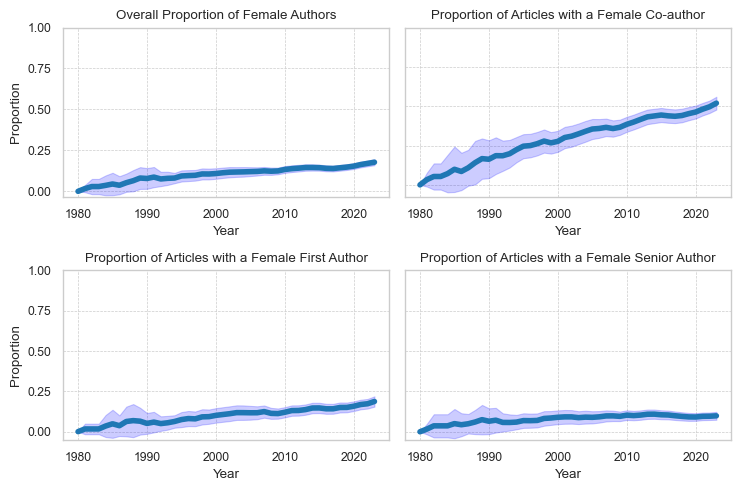

In [328]:
sns.set_context("paper")
sns.set_style("whitegrid")
# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(7.5, 5))

# Call the function with each ax object
generate_time_series_plot(df, 'female_prop', axs[0, 0], yticks=[0.0,.25,0.5,.75,1], title="Overall Proportion of Female Authors")
generate_time_series_plot(df, 'female', axs[0, 1], yticks=[0.0,.25,0.5,.75,1], title="Proportion of Articles with a Female Co-author")
generate_time_series_plot(df, 'female_first', axs[1, 0], yticks=[0.0,.25,0.5,.75,1], title="Proportion of Articles with a Female First Author")
generate_time_series_plot(df, 'female_last', axs[1, 1], yticks=[0.0,.25,0.5,.75,1], title="Proportion of Articles with a Female Senior Author")

# drop the y labels and the yticks for the right column, but dont lose the gridlines
axs[0, 1].set_ylabel("")
axs[0, 1].set_yticklabels([])
axs[1, 1].set_ylabel("")
axs[1, 1].set_yticklabels([])

# Adjust space between plots for better visualization
plt.tight_layout()

# Show the plots
plt.show()



In [349]:
# get a sense of the average values for each journal, and what year each journal reached the average

# Convert booleans to integer
df['female'] = df['female'].astype(int)
df['female_first'] = df['female_first'].astype(int)
df['female_last'] = df['female_last'].astype(int)

# Filter the dataframe for only those journals in the 'long_names' list
filtered_df = df[df['journal'].isin(long_names)]

# Initialize a results list
results = []

# For each column and for each journal, calculate the desired statistics
for col in ['female_prop', 'female', 'female_first', 'female_last']:
    col_results = []
    
    for journal in long_names:
        journal_data = filtered_df[filtered_df['journal'] == journal]
        
        # Compute mean
        mean_val = journal_data[col].mean()
        
        # Find the year closest to the mean value. We'll use the absolute difference.
        closest_row = journal_data.iloc[(journal_data[col]-mean_val).abs().argsort()[:1]]
        mean_year = closest_row['pub_year'].values[0]
        
        col_results.append({
            'column': col,
            'journal': journal,
            'mean': mean_val,
            'mean_year': mean_year
        })

    # Sort results for the current column by 'mean_year'
    sorted_col_results = sorted(col_results, key=lambda x: x['mean_year'])
    results.extend(sorted_col_results)

# Convert results to a DataFrame for better visualization
stats_df = pd.DataFrame(results).set_index(['column', 'journal'])

stats_df


mean  mean_year
column       journal                                      
female_prop  J NEUROSURG               0.089489       2002
             PEDIATR NEUROSURG         0.117274       2008
             NEUROSURGERY              0.109764       2008
             J SPINAL DISORD TECH      0.072405       2011
             SPINE                     0.121847       2015
             SPINE JOURNAL             0.109585       2016
             J BONE JOINT SURG-AM VOL  0.085972       2016
             EUR SPINE J               0.131125       2017
             J NEUROSURG-PEDIATR       0.159331       2018
             CHILDS NERV SYST          0.171385       2019
             SPINE DEFORM              0.180349       2020
             J NEUROSURG-SPINE         0.080718       2021
female       CHILDS NERV SYST          0.463114       1992
             SPINE                     0.392476       1992
             NEUROSURGERY              0.319249       1992
             PEDIATR NEUROSURG         0.360231       1993
             J NEUROSURG               0.280702       2005
             EUR SPINE J               0.411021       2011
             J NEUROSURG-PEDIATR       0.508811       2011
             SPINE JOURNAL             0.350649       2011
             J NEUROSURG-SPINE         0.339901       2011
             J SPINAL DISORD TECH      0.243421       2011
             SPINE DEFORM              0.546039       2021
             J BONE JOINT SURG-AM VOL  0.253731       2023
female_first CHILDS NERV SYST          0.173530       1992
             SPINE                     0.112401       1992
             J BONE JOINT SURG-AM VOL  0.070896       1992
             J NEUROSURG               0.083333       1992
             NEUROSURGERY              0.093897       1992
             PEDIATR NEUROSURG         0.112392       1993
             EUR SPINE J               0.133695       2011
             J NEUROSURG-PEDIATR       0.158590       2011
             SPINE JOURNAL             0.103896       2011
             J NEUROSURG-SPINE         0.103448       2011
             J SPINAL DISORD TECH      0.085526       2011
             SPINE DEFORM              0.175589       2019
female_last  CHILDS NERV SYST          0.120898       1992
             SPINE                     0.088713       1992
             J BONE JOINT SURG-AM VOL  0.089552       1992
             NEUROSURGERY              0.075117       1992
             PEDIATR NEUROSURG         0.092219       1993
             J NEUROSURG               0.074561       2005
             EUR SPINE J               0.084011       2011
             J NEUROSURG-PEDIATR       0.061674       2011
             SPINE JOURNAL             0.074675       2011
             J NEUROSURG-SPINE         0.024631       2011
             J SPINAL DISORD TECH      0.065789       2011
             SPINE DEFORM              0.068522       2019

In [337]:
# define a function to plot multiple series on a single plot, for the top 12 journals

def generate_plot(df, column, long_names, journal_dict, yticks, title):
    # Filter the dataframe
    spine_auths_top = df[df["journal"].isin(long_names)].query("pub_year >= 1980") # since sparse data before 1980, we'll just look at 1980 and later

    # Replace the long names with the short abbreviations in the 'journal' column
    spine_auths_top["journal"] = spine_auths_top["journal"].replace(journal_dict)

    # Pivot dataframe
    spine_auths_top_pivot = spine_auths_top.pivot_table(values=column, index="pub_year", columns="journal")
    
    # Rename columns
    spine_auths_top_pivot = spine_auths_top_pivot.reset_index().rename(columns={"pub_year": "year"})

    column_order = (
        spine_auths_top_pivot.query("year > 2020") # this allows us to plot in order of most recent proportion
        .max(axis=0)[1:]
        .sort_values(ascending=False)
        .index
    )

    # Calculate the rolling 5-year average to smooth the time series
    spine_auths_top_pivot_smooth = spine_auths_top_pivot.rolling(window=5, center=False).mean()
    spine_auths_top_pivot_smooth["SPINE DEFORM"] = spine_auths_top_pivot["SPINE DEFORM"] # since this journal is relatively new, we'll just use the raw data

    # Create small multiple time series plot
    g = sns.relplot(
        data=spine_auths_top_pivot_smooth.melt(id_vars=["year"], var_name="journal"),
        x="year",
        y="value",
        col="journal",
        hue="journal",
        col_order=column_order,
        kind="line",
        palette="crest",
        linewidth=4,
        zorder=5,
        col_wrap=6,
        height=4,
        aspect=1,
        legend=False,
    )

    # Iterate over each subplot to customize further
    for journal, ax in g.axes_dict.items():
        # Title annotation
        ax.text(0.05, 0.85, journal, transform=ax.transAxes, fontweight="bold", size=24)

        # Background time series
        long_df = spine_auths_top_pivot_smooth.melt(id_vars=["year"], var_name="journal")
        sns.lineplot(
            data=long_df,
            x="year",
            y="value",
            estimator=None,
            color=".7",
            linewidth=1,
            ax=ax,
        )
        ax.set_yticks(yticks, size=26)
        ax.set_xticks([1988, 1998, 2008, 2018], size=32)

    # Tweak the plot
    g.set_titles("")
    g.set_axis_labels("", "", size=26)
    g.fig.text(0.01, 0.5, "Proportion", va="center", rotation="vertical", fontsize=34)
    g.fig.text(0.5, 0, "Year", va="center", rotation="horizontal", fontsize=34)

    for ax in g.axes.flat:  # iterate over all subplot axes
        ax.tick_params(axis="y", labelsize=24)
        ax.tick_params(axis="x", labelsize=20)

    # Adjustments
    g.fig.subplots_adjust(left=0.065, top=0.90, bottom=0.10)

    # Add the suptitle
    g.fig.suptitle(f"{title}", fontsize=32, y=0.98)

    plt.show()


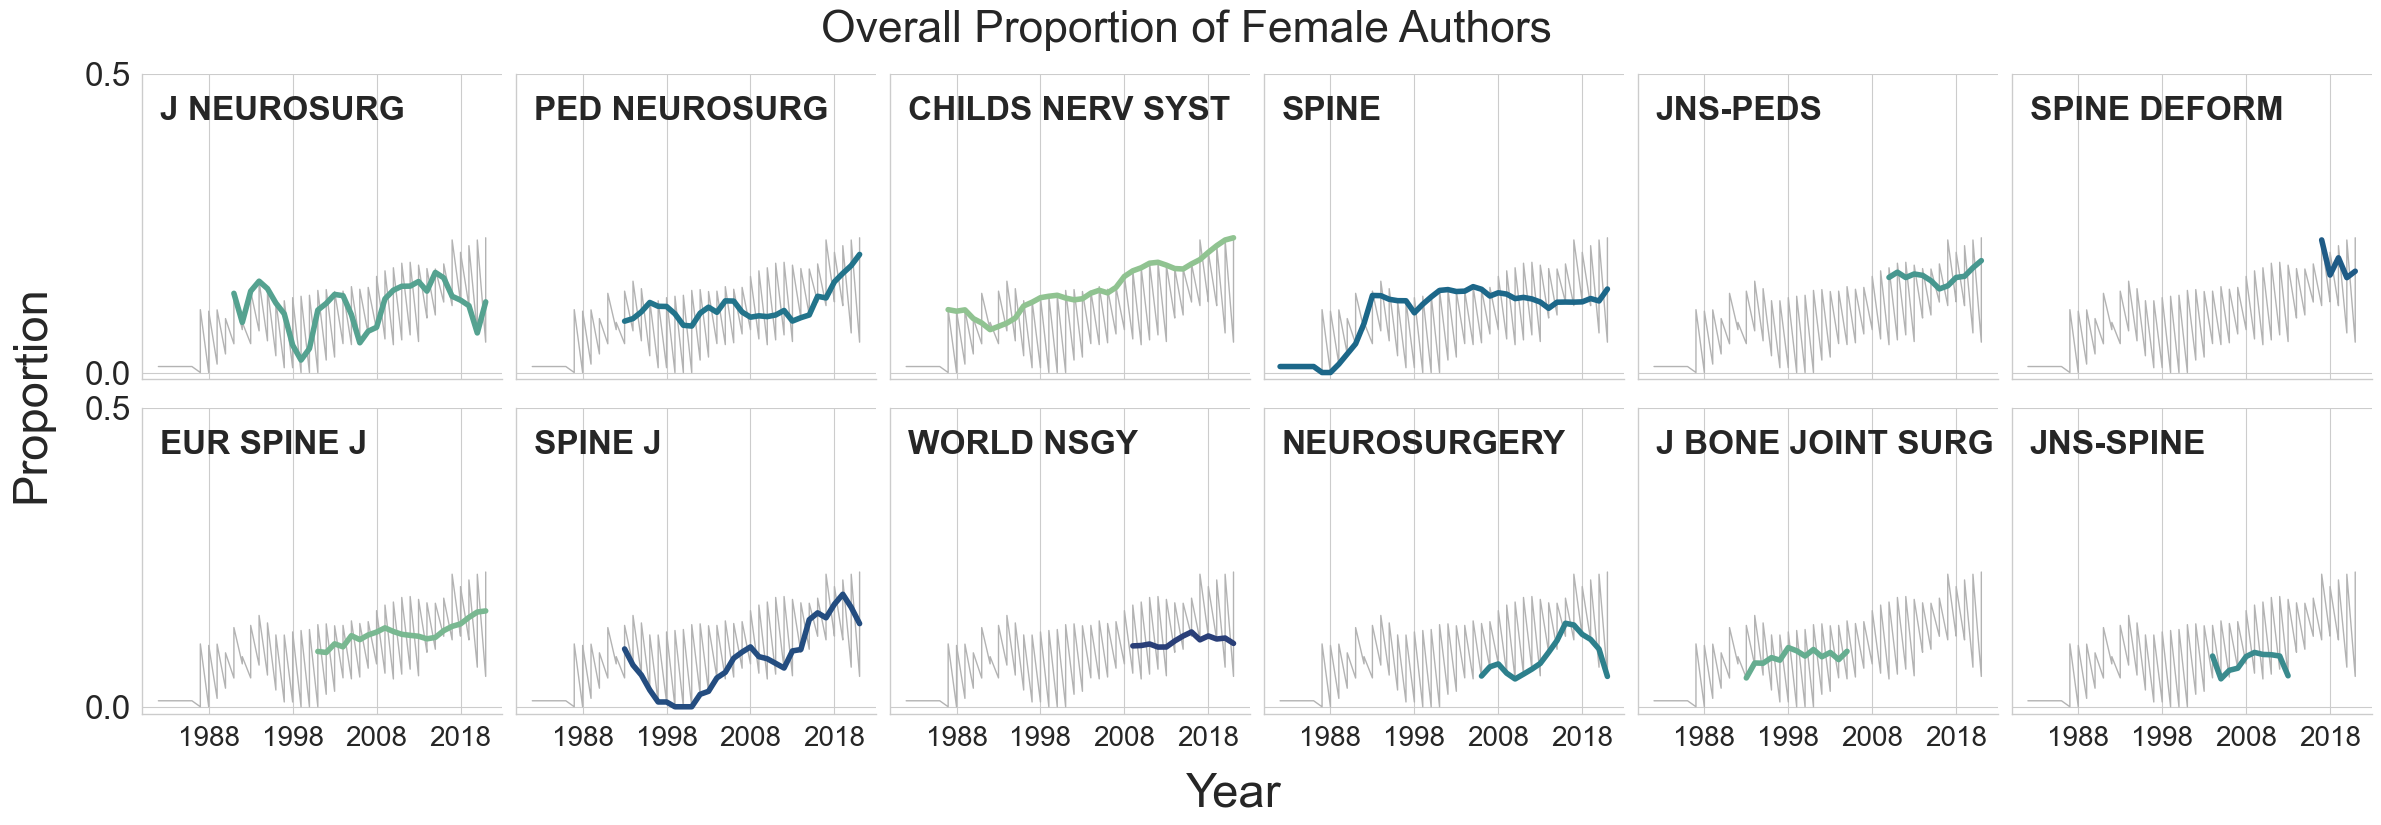

In [350]:
generate_plot(df, "female_prop", long_names, journal_dict,[0.0, 0.5], "Overall Proportion of Female Authors")

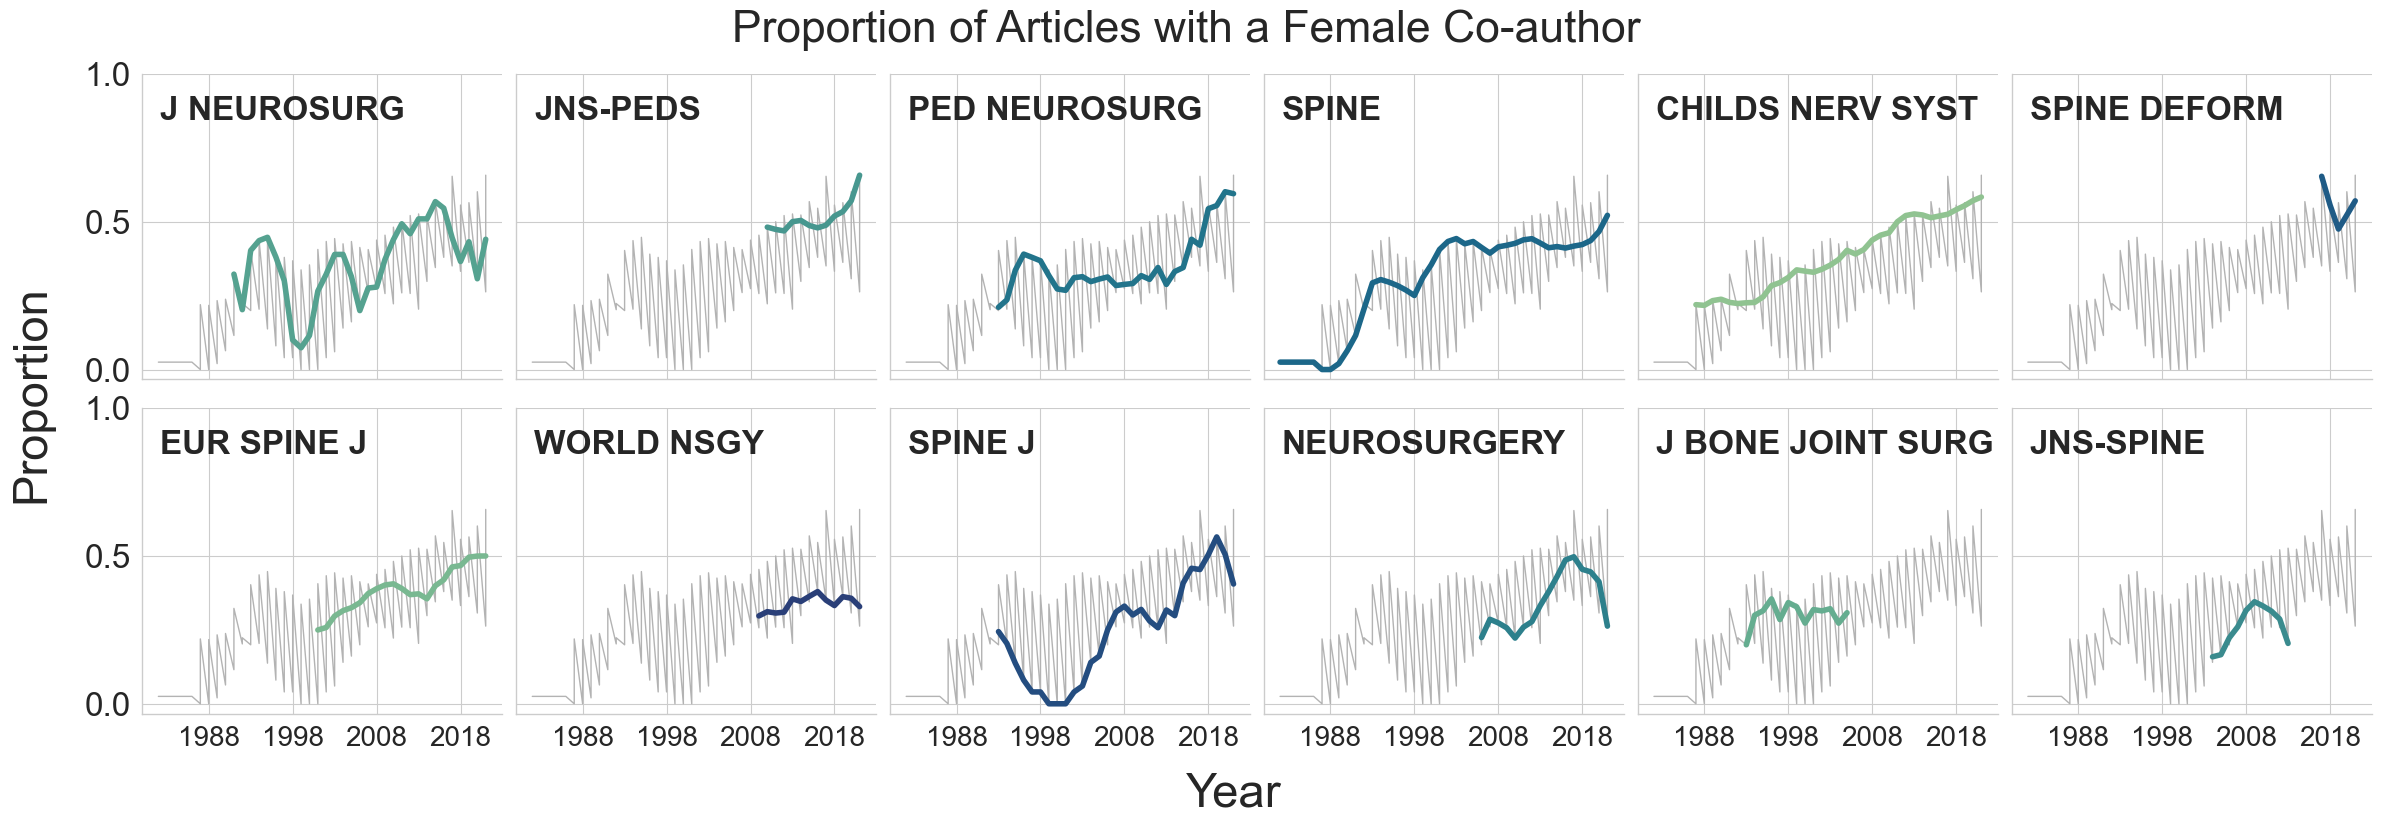

In [351]:
generate_plot(df, "female", long_names, journal_dict,[0.0, 0.5, 1], "Proportion of Articles with a Female Co-author")

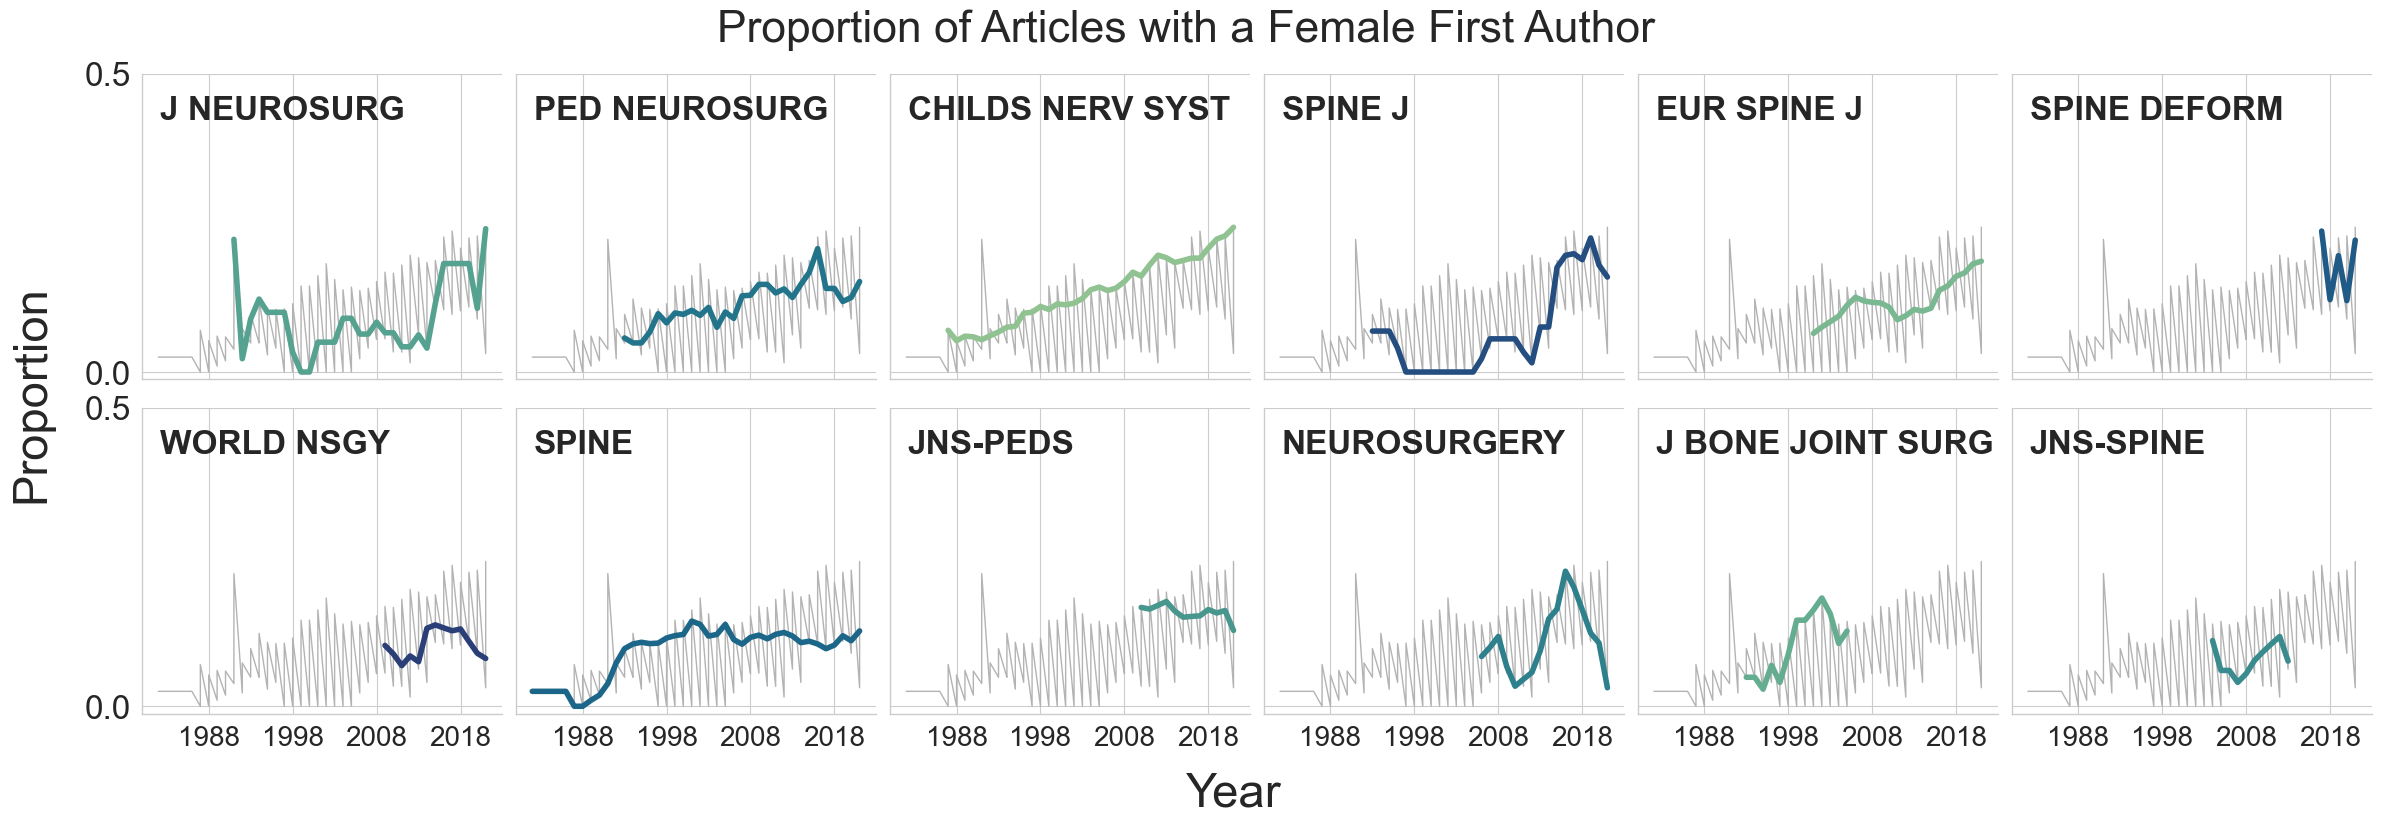

In [352]:
generate_plot(df, "female_first", long_names, journal_dict,[0.0, 0.5], "Proportion of Articles with a Female First Author")

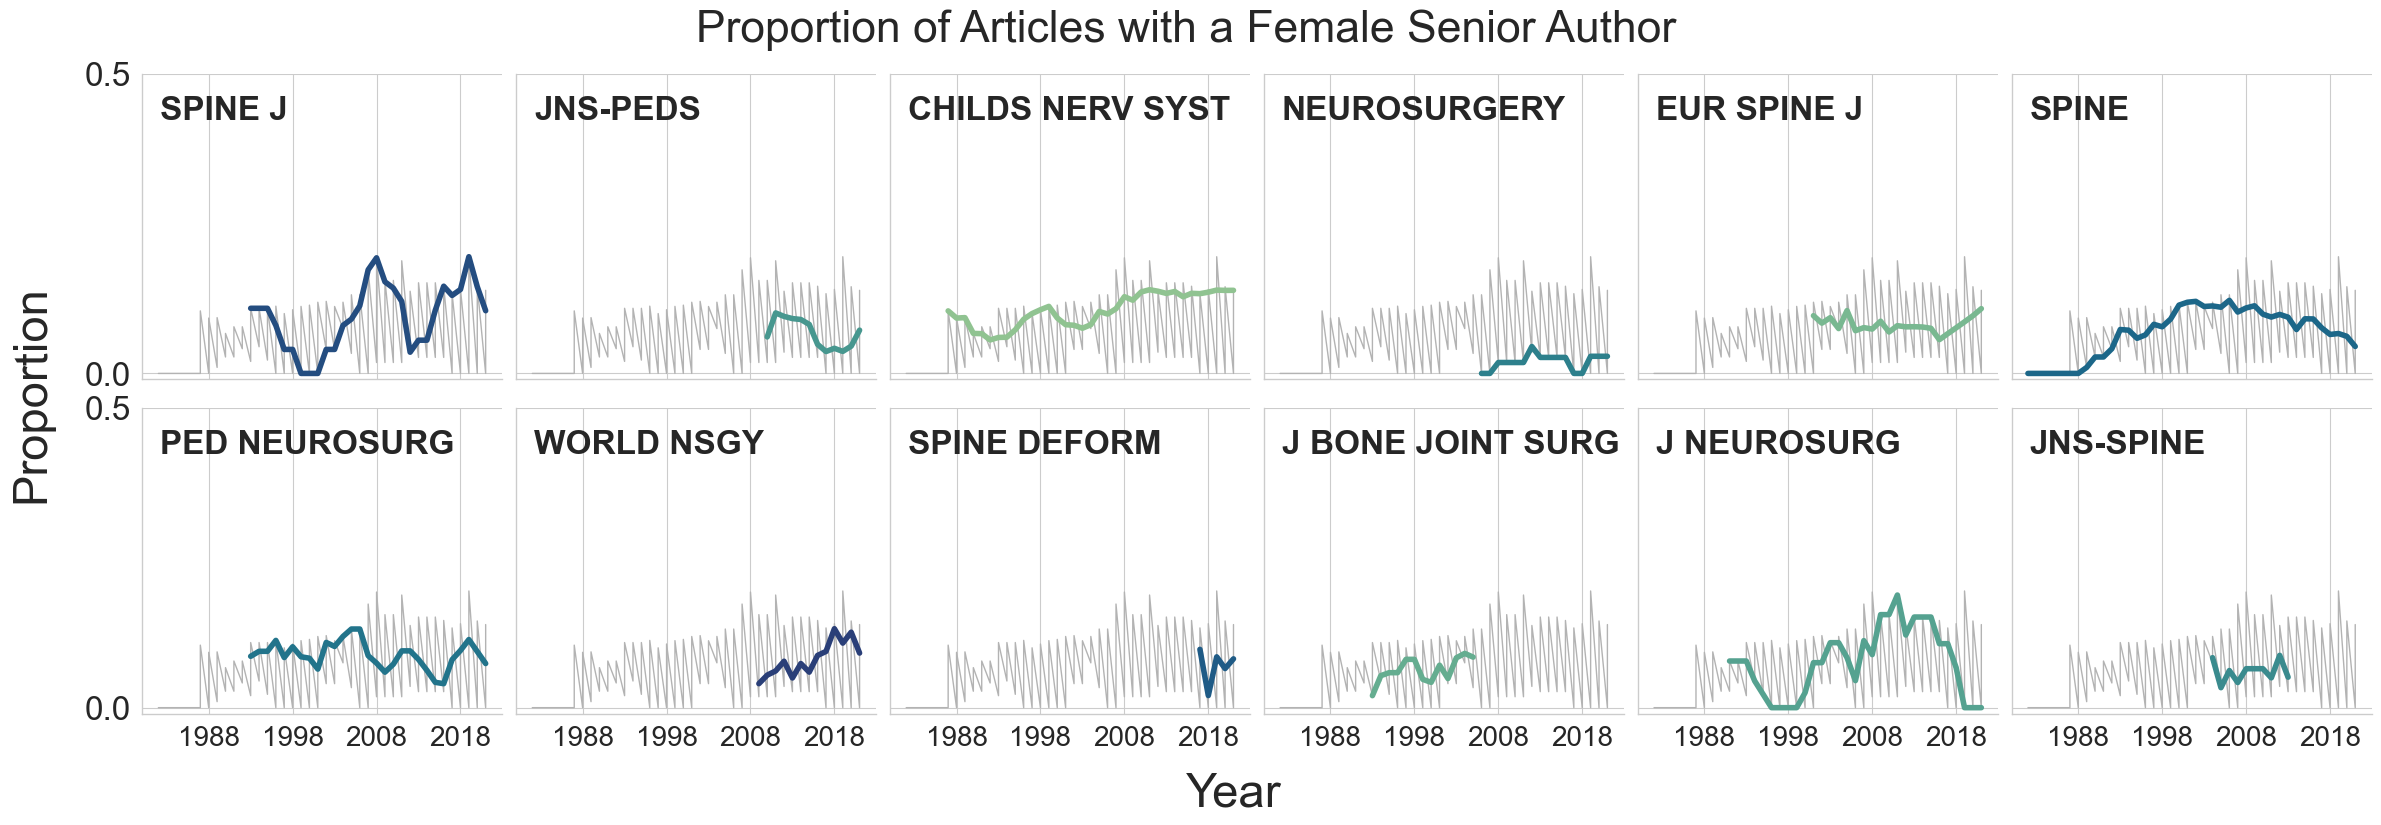

In [353]:
generate_plot(df, "female_last", long_names, journal_dict,[0.0, 0.5], "Proportion of Articles with a Female Senior Author")

### now lets look at race/ethnicity representation over time

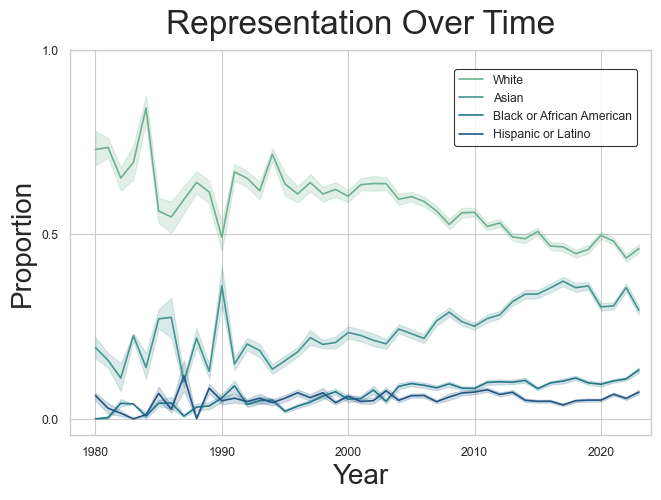

In [365]:
melted_df = (
    df.melt(
        id_vars=["pub_year", "journal"],
        value_vars=["prop_white", "prop_black", "prop_asian", "prop_hispanic"],
        var_name="race",
        value_name="proportion",
    )
    .replace(
        {
            "prop_white": "White",
            "prop_asian": "Asian",
            "prop_black": "Black or African American",
            "prop_hispanic": "Hispanic or Latino",
        }
    )
    .sort_values(by=["race", "pub_year"])
)

melted_df["rolling_avg"] = melted_df.groupby("race")["proportion"].transform(
    lambda x: x.rolling(10, min_periods=1).mean()
)

# Plot the proportions of each race by year
plt.figure(figsize=(7.5, 5))
sns.set_context("paper")
sns.set_style("whitegrid")

g = sns.lineplot(
    data=melted_df.query("pub_year >=1980"),
    x="pub_year",
    y="rolling_avg",
    hue="race",
    hue_order=["White", "Asian", "Black or African American", "Hispanic or Latino"],
    palette="crest",
)
g.legend(
    loc="center left",
    bbox_to_anchor=(0.65, 0.85),
    title="",
    frameon=True,
    edgecolor="black",
)

plt.xlabel("Year", size=20)
plt.ylabel("Proportion", size=20)
plt.title("Representation Over Time", size=24, y=1.02)
g.set_xticks([1980, 1990, 2000, 2010, 2020], size=26)
g.set_yticks([0.0, 0.5, 1.0], size=26)
g.set_xlim(1978, 2024)


plt.show()